Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [1]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_10) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n"

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [2]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0
# !python -m pip install pytorch-lightning==1.6.0

In [3]:
import sys

# For google colab
# !python -m pip install pytorch-lightning==1.6.0 > /dev/null

# For anaconda/regular python
!{sys.executable} -m pip install pytorch-lightning==1.6.0 > /dev/null
# 1. Preparation

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [5]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
[2022-11-07T15:31:03Z ERROR rustboard_core::disk_logdir] While walking log directory: IO error for operation on lightning_logs: No such file or directory (os error 2)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E1107 16:31:04.905372 4673177088 program.py:298] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC v2 dataset is an extension of the MSRC v1 dataset from Microsoft Research in Cambridge. It contains *591* images and *23* object classes with accurate pixel-wise labeled images. 



The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 

<img src='images/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [6]:
download_url = 'https://i2dl.dvl.in.tum.de/downloads/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


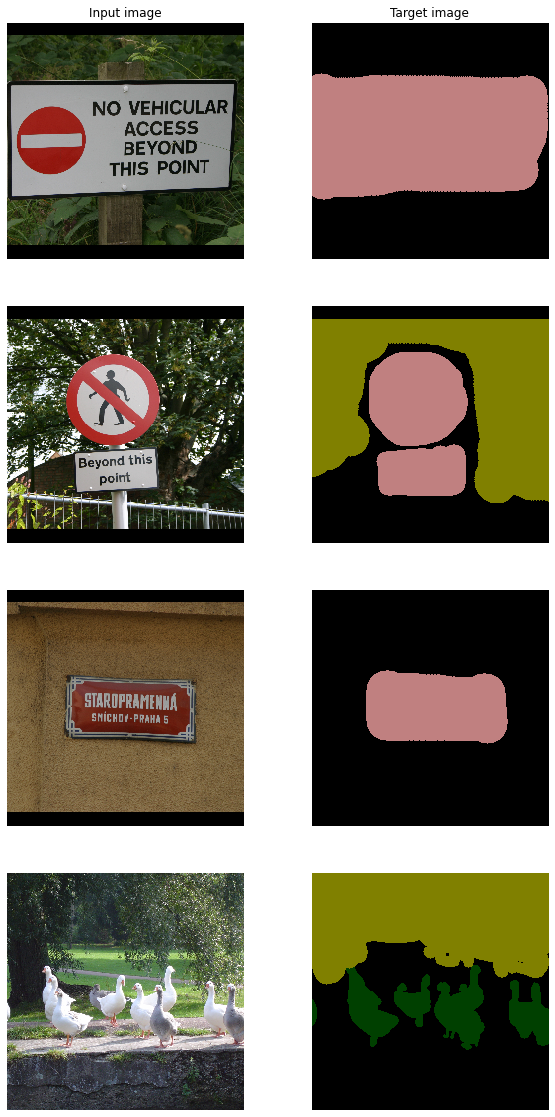

In [7]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

In [8]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
#visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [9]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2075)
tensor(2.9404)
tensor(2.2075)
tensor(3.2075)


### Note: Non-zero loss for the first sample
The output of our dummy model is one-hot-coded tensor. Since there is `softmax` function in the `nn.CrossEntropyLoss` function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.  

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [10]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        out = outputs['out']
        _, preds = torch.max(out, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
#print(evaluate_model(dummy_model, test_loader))

You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [11]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class,
    "learning_rate": 0.01,
    "momentum": 0.99
}

In [12]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Your model has 57.098 mio. params but must have less than 5.000 mio. params. Simplify your model before submitting it. You won't need that many params :)
Your model is too large! The size is 228.4 MB, but it must be less than 50.0 MB. Please simplify your model before submitting.
Some tests failed for your model. Tests passed: 0/2


## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [13]:
model = SegmentationNN(hparams=hparams)
########################################################################
# TODO - Train Your Model                                              #
########################################################################
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models.segmentation import lraspp_mobilenet_v3_large
from torchvision import models

#model = lraspp_mobilenet_v3_large(num_classes=23)
model = models.segmentation.fcn_resnet50(num_classes=23)


criterion = nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

#model = lraspp_mobilenet_v3_large(num_classes=23)

num_epochs = 20
batch_size = 32
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = num_workers)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = False, num_workers = num_workers)

"""
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
"""

epochs = 4
min_valid_loss = np.inf

for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs['out'], labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in val_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        outputs = model(data)
        loss = criterion(outputs['out'], labels)
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        
"""

logger = TensorBoardLogger(save_dir='lightning logs')

trainer = pl.Trainer(
    max_epochs=num_epochs,
    logger=logger,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader, val_dataloader)
"""
print(model)



#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

Epoch 1 		 Training Loss: 2.7524507310655384 		 Validation Loss: 33.111236214637756
Validation Loss Decreased(inf--->66.222472) 	 Saving The Model
Epoch 2 		 Training Loss: 1.2910764614741008 		 Validation Loss: 15.204531490802765
Validation Loss Decreased(66.222472--->30.409063) 	 Saving The Model
Epoch 3 		 Training Loss: 0.6916749874750773 		 Validation Loss: 6.870795160531998
Validation Loss Decreased(30.409063--->13.741590) 	 Saving The Model
Epoch 4 		 Training Loss: 0.45617111689514583 		 Validation Loss: 5.274765998125076
Validation Loss Decreased(13.741590--->10.549532) 	 Saving The Model
FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(


# 3. Test your Model

In [14]:
test(evaluate_model(model, test_loader))

Validation-Accuracy: 87.13149666047345%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

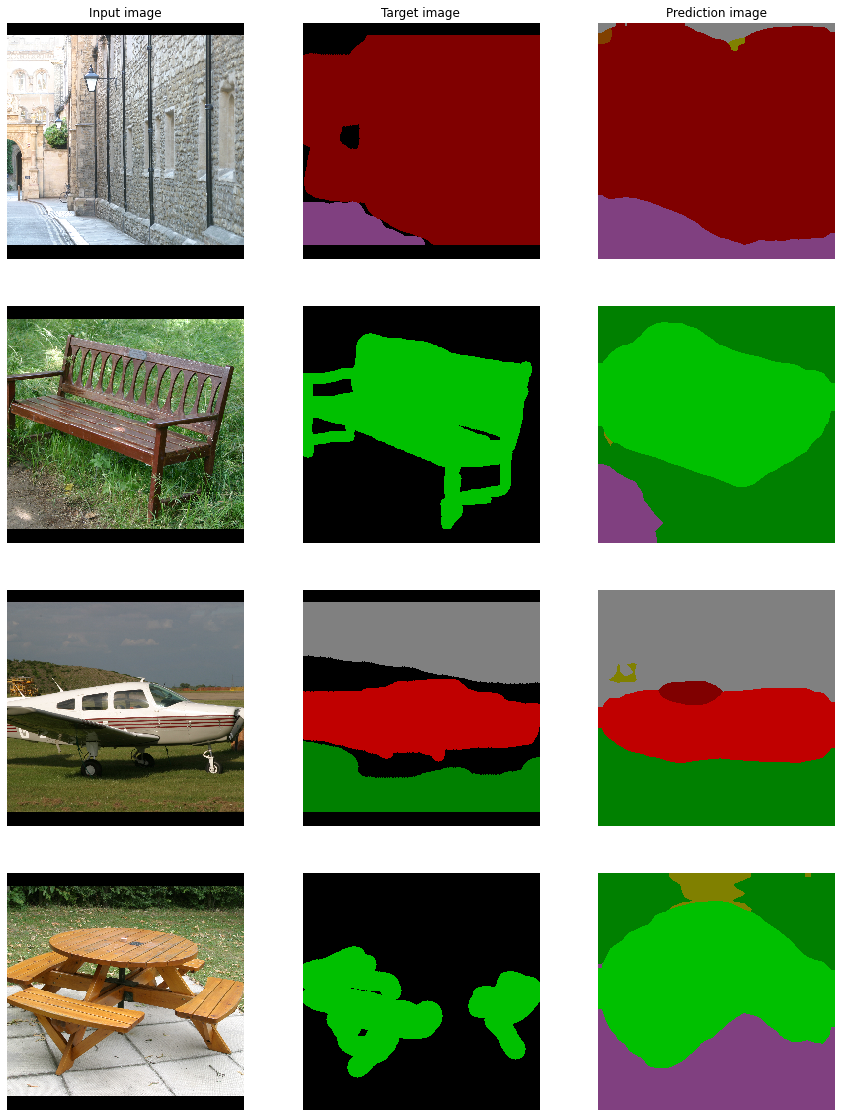

In [15]:
visualizer(model, test_data)

## Save the Model for Submission

When you are satisfied with your training, save the model for [submission](https://i2dl.dvl.in.tum.de/submission/). In order to be eligible for the bonus points you have to achieve an accuracy above __64%__.

In [16]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

Your model is too large! The size is 132.2 MB, but it must be less than 50 MB. Please simplify your model before submitting.


False

In [17]:
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise10')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_segmentation_nn copy.ipynb', '1_segmentation_nn.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_segmentation_nn copy.ipynb
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /Users/cemuyuk/Desktop/Semesters/SoSe22/I2DL/output/exercise10.zip


# Submission Instructions

Congratulations! You've just built your first semantic segmentation model with PyTorch Lightning! To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.dvl.in.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Log into [our submission page](https://i2dl.dvl.in.tum.de/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
3. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
- Submission start: __Tuesday, July 12, 2022__
- Submission deadline: __Monday, July 18, 2022 - 23:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform) for this exercise so that we can do better next time! :)